In [1]:
#@title imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import re
from google.colab import drive
import warnings
import seaborn as sns
from functools import reduce

In [2]:
#@title warning silencing
# silence warnings
# (This has been checked, the warnings only include pandas deprecation warnings)
warnings.filterwarnings('ignore')

In [3]:
#@title loading data
drive.mount('/mnt/drive')
data_path = '/mnt/drive/My Drive/Data/' # Must add shortcut for Data from shared drive in 'My Drive'

unwanted = []

files = [data_path + file for file in os.listdir(data_path) if (file.endswith('.csv') or file.endswith('.xlsx')) and file not in unwanted]

# selection = 5
# selection = '/mnt/drive/My Drive/Data/10001.Tab_Unemployment_rate.csv'
#"""
selection = [
  '/mnt/drive/My Drive/Data/10002.Tab_GDP.csv',
  '/mnt/drive/My Drive/Data/10003.Tab_Inflation.csv',
  '/mnt/drive/My Drive/Data/10004.Tab_UK_population.csv',
  '/mnt/drive/My Drive/Data/10000.Tab_Employment_rate.csv',
  '/mnt/drive/My Drive/Data/10001.Tab_Unemployment_rate.csv',
  '/mnt/drive/My Drive/Data/10008.Tab_exchange_rate.csv',
  '/mnt/drive/My Drive/Data/10015.Tab_brexit_gdp.csv',
  '/mnt/drive/My Drive/Data/10016.Tab_brexit_inflation.csv',
  '/mnt/drive/My Drive/Data/10018.Tab_brexit_migration_to_uk.csv',
  '/mnt/drive/My Drive/Data/redundancy-all.csv',
  '/mnt/drive/My Drive/Data/mortgage-interest-payments.csv'
  ] # TODO: I would wnat to use xlsxs too, most of them need a pivot operation performed
#"""
len(files), files

Mounted at /mnt/drive


(28,
 ['/mnt/drive/My Drive/Data/10002.Tab_GDP.csv',
  '/mnt/drive/My Drive/Data/10003.Tab_Inflation.csv',
  '/mnt/drive/My Drive/Data/10004.Tab_UK_population.csv',
  '/mnt/drive/My Drive/Data/10000.Tab_Employment_rate.csv',
  '/mnt/drive/My Drive/Data/10001.Tab_Unemployment_rate.csv',
  '/mnt/drive/My Drive/Data/10008.Tab_exchange_rate.csv',
  '/mnt/drive/My Drive/Data/10007.Tab_business_demography.xlsx',
  '/mnt/drive/My Drive/Data/10009.Tab_trades_exports.xlsx',
  '/mnt/drive/My Drive/Data/10010.Tab_trades_imports.xlsx',
  '/mnt/drive/My Drive/Data/10005.Tab_Redundancies.xlsx',
  '/mnt/drive/My Drive/Data/10006.Tab_Non-financial_business_economy.xlsx',
  '/mnt/drive/My Drive/Data/10015.Tab_brexit_gdp.csv',
  '/mnt/drive/My Drive/Data/10016.Tab_brexit_inflation.csv',
  '/mnt/drive/My Drive/Data/10017.Tab_brexit_job_vacancies.csv',
  '/mnt/drive/My Drive/Data/10018.Tab_brexit_migration_to_uk.csv',
  '/mnt/drive/My Drive/Data/10019.Tab_brexit_pound_to_euro.csv',
  '/mnt/drive/My Drive/

In [4]:
#@title parser functions
def backup_time_series_to_df(df, column=0, date_pattern=r"^\d{4}\s[A-Za-z]{3}$"):
    """
    Trims DataFrame to the first run of rows that match a specified date pattern.
    To be used if the automatic detection and parsing of the date column fails.

    Parameters:
    - df: DataFrame to be trimmed.
    - column (int or str, optional): The column to check for date patterns. Can be an index (int) or column name (str).
      Default is 0 (the first column).
    - date_pattern (str, optional): A regex pattern to match the date format.
      Default is '^\d{4}\s[A-Za-z]{3}$' (matches a year followed by a 3-letter month abbreviation).

    Returns:
    - pd.DataFrame: A DataFrame that is trimmed to include only rows where the specified column matches the date pattern,
      starting from the first matching row to the last continuous block. Returns original df if no matches found.

    Raises:
    - ValueError: If the specified column does not exist (for string names).
    """
    if df.empty:
        return df # Return empty if input is empty

    col_name = None
    # Ensure column is either an index or column name
    if isinstance(column, int):
        if column < 0 or column >= len(df.columns):
            print(f"  - Warning (backup_time_series_to_df): Column index {column} is out of range. Using first column.")
            column = 0 # Default to first column if index is invalid
        # Use iloc for selecting by integer position, ensure column data is string
        try:
            column_data = df.iloc[:, column].astype(str)
            col_name = df.columns[column] # Get name for potential error message
        except IndexError:
            print("  - Warning (backup_time_series_to_df): Could not access column by index. Returning original DataFrame.")
            return df # Cannot proceed
    elif isinstance(column, str):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' does not exist.")
        column_data = df[column].astype(str) # Ensure string type for matching
        col_name = column
    else:
        raise ValueError("The 'column' argument must be either an index or column name.")

    # Match the dates using the provided pattern (handle potential NaN values)
    matches = column_data.str.match(date_pattern, na=False) # na=False treats NaN as no match

    # If there are no matches, return the original DataFrame
    if not matches.any():
        # print(f"  - Info (backup_time_series_to_df): No dates matching pattern '{date_pattern}' found in column '{col_name}'.")
        return df # Return original df if no match found

    # Find index label of first True and last True in the *first continuous block*
    first_match_idx = matches[matches].index[0]

    # Find where the continuous block of matches ends
    last_match_idx = first_match_idx
    for idx in matches.loc[first_match_idx:].index:
        if matches[idx]:
            last_match_idx = idx
        else:
            break # Stop at the first non-match after the start

    # Slice the dataframe based on the valid date range using index labels
    df_trimmed = df.loc[first_match_idx:last_match_idx].copy()

    return df_trimmed


def detect_date_column(df: pd.DataFrame) -> str:
    """
    Automatically detects the column in the DataFrame that contains date-like information,
    including quarterly data in the format "YYYY Qx".

    Parameters:
    - df (pd.DataFrame): The DataFrame to search for date columns.

    Returns:
    - str: The name of the detected date column, or None if no suitable date column is found.
    """
    if df.empty:
        return None

    possible_date_counts = {}
    potential_date_cols = []

    for column in df.columns:
        # Skip columns that are likely all NaN or empty
        if df[column].isna().all():
             continue

        col_str = df[column].astype(str) # Work with string representation for checks

        # Check 1: "YYYY Qx" format
        if col_str.str.contains(r'\b\d{4}\sQ[1-4]\b', na=False).any():
             potential_date_cols.append(column)
             continue # Prioritize quarterly if found

        # Check 2: Standard date formats using pd.to_datetime
        try:
            # Attempt conversion on a sample or non-NA values for efficiency?
            # For now, try on the whole column but coerce errors
            dt_col = pd.to_datetime(df[column], errors='coerce')
            # Check if a significant portion (>50% of non-NA) converted successfully
            if dt_col.notna().sum() > 0.5 * df[column].notna().sum() and df[column].notna().sum() > 0:
                potential_date_cols.append(column)
                possible_date_counts[column] = dt_col.notna().sum()
        except Exception: # Catch broader exceptions during conversion
            pass

    # If specific formats found, return the first one
    if potential_date_cols:
        # Maybe prioritize based on counts if multiple found? For now, first detected.
        # If quarterly was found, it would be added first typically.
         return potential_date_cols[0]


    # Fallback Check 3: At least *some* (e.g., 10%) date-like strings?
    # This check was less reliable, let's refine or remove if the above are sufficient.
    # Re-evaluating based on pd.to_datetime success rate might be better.
    if possible_date_counts:
        # Find column with the maximum number of successful conversions
        max_date_column = max(possible_date_counts, key=possible_date_counts.get)
        # Use a threshold relative to the number of non-NA values in that column
        if possible_date_counts[max_date_column] / df[max_date_column].notna().sum() > 0.1:
            return max_date_column


    return None # Return None if no suitable date column is found


def convert_quarter_to_date(quarter_str: str) -> pd.Timestamp:
    """
    Converts a quarterly string (e.g., "2021 Q1") to the corresponding date (e.g., "2021-01-01").
    This function is flexible and can work with quarterly strings containing "YYYY Qx".

    Parameters:
    - quarter_str (str): The quarterly string (e.g., "2021 Q1").

    Returns:
    - pd.Timestamp: The corresponding datetime object (e.g., "2021-01-01"), or pd.NaT if conversion fails.
    """
    if not isinstance(quarter_str, str):
        return pd.NaT

    # Use regex to extract year and quarter for more robustness
    match = re.search(r'(\b\d{4}\b)\s*Q([1-4])', quarter_str)
    if match:
        try:
            year = int(match.group(1))
            quarter = int(match.group(2))
            # Map quarters to the first month of each quarter
            quarter_months = {1: 1, 2: 4, 3: 7, 4: 10}
            month = quarter_months[quarter]
            return pd.to_datetime(f"{year}-{month:02d}-01")
        except (ValueError, TypeError, KeyError):
            return pd.NaT # Handle potential errors during conversion
    return pd.NaT  # Return NaT if the input string is not in a valid "YYYY Qx" format


def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans a DataFrame by stripping column names, detecting and converting a date column
    to datetime format, setting it as index, and sorting.

    Parameters:
    - df (pd.DataFrame): The input DataFrame. Assumes header might be row 0.

    Returns:
    - pd.DataFrame: The cleaned DataFrame with a 'Date' index, or None if cleaning fails
                    (e.g., no date column found, or DataFrame becomes empty).
    """
    if df is None or df.empty:
        print("  - Info (clean_dataset): Input DataFrame is None or empty.")
        return None

    # Make a copy to avoid modifying the original DataFrame passed to the function
    df_cleaned = df.copy()

    # Clean column names (remove leading/trailing spaces, handle potential non-string types)
    df_cleaned.columns = [str(col).strip() if col is not None else f'Unnamed:{i}' for i, col in enumerate(df_cleaned.columns)]

    date_column = detect_date_column(df_cleaned)

    if date_column is None:
        print("  - Info (clean_dataset): No date column detected.")
        return None # Cannot proceed without a date column

    original_date_column_name = date_column # Keep track for potential backup usage

    # Attempt conversion and cleaning
    try:
        date_col_series = df_cleaned[date_column]

        # Check if the column contains quarterly-like data (e.g., "YYYY Qx")
        # Perform this check on string representation
        if date_col_series.astype(str).str.contains(r'\b\d{4}\sQ[1-4]\b', na=False).any():
            # Convert the "YYYY Qx" format to datetime dynamically
            new_date_column = date_col_series.apply(convert_quarter_to_date)
            # If conversion results in mostly NaT, maybe try backup or assume bad data
            if new_date_column.isna().mean() > 0.7:
                 print(f"  - Info (clean_dataset): High NaT rate after quarterly conversion for column '{date_column}'. Attempting backup.")
                 # Try backup using month pattern first
                 df_backup = backup_time_series_to_df(df_cleaned, column=original_date_column_name)
                 if df_backup.empty or df_backup.equals(df_cleaned): # Check if backup did anything
                     # If month pattern failed or returned original, try quarter pattern backup
                     print(f"  - Info (clean_dataset): Month backup ineffective, trying quarter pattern backup.")
                     df_backup = backup_time_series_to_df(df_cleaned, column=original_date_column_name, date_pattern=r"^\d{4}\sQ[1-4]$")

                 # If backup resulted in a change, re-run cleaning on the trimmed data
                 if not df_backup.equals(df_cleaned) and not df_backup.empty:
                     print("  - Info (clean_dataset): Backup trim applied. Re-running clean_dataset.")
                     # Recursive call - be careful with depth if issues arise
                     # Alternatively, re-implement the cleaning steps here for the backup df
                     return clean_dataset(df_backup) # Re-clean the potentially trimmed data
                 else:
                     print("  - Warning (clean_dataset): Backup methods failed to isolate time series. Cannot clean.")
                     return None # Backup failed

            else:
                # Quarterly conversion seemed okay, assign it back
                 df_cleaned[date_column] = new_date_column

        else:
            # For potentially standard date formats, convert to datetime
            df_cleaned[date_column] = pd.to_datetime(df_cleaned[date_column], errors='coerce')

        # Check for excessive NaNs after conversion
        if df_cleaned[date_column].isna().all():
             print(f"  - Warning (clean_dataset): Date column '{date_column}' is all NaT after conversion.")
             return None


        # Rename the date column to 'Date'
        df_cleaned.rename(columns={date_column: 'Date'}, inplace=True)
        date_column = 'Date' # Update variable name

        # Find the first valid date index label
        first_valid_index_label = df_cleaned[date_column].first_valid_index()

        # Trim the DataFrame to start from the first valid date
        if first_valid_index_label is not None:
            df_cleaned = df_cleaned.loc[first_valid_index_label:].copy()
        else:
             print("  - Warning (clean_dataset): No valid dates found after conversion.")
             return None # No valid dates found

        if df_cleaned.empty:
             print("  - Warning (clean_dataset): DataFrame empty after trimming to first valid date.")
             return None


        # Final checks: ensure 'Date' column is datetime64[ns] and sort
        df_cleaned[date_column] = pd.to_datetime(df_cleaned[date_column]) # Ensure dtype
        df_cleaned = df_cleaned.sort_values(by=date_column)

        # Set 'Date' as index
        df_cleaned.set_index(date_column, inplace=True)

        # Optional: Drop rows where all other columns are NaN?
        # df_cleaned.dropna(axis=0, how='all', inplace=True)

        return df_cleaned

    except Exception as e:
        print(f"  - Error during cleaning dataset (column '{original_date_column_name}'): {e}")
        return None # Return None if any error occurs during the cleaning process

In [5]:
#@title csv -> dataframe function
def general_to_df(*file_paths):
    """
    Reads multiple CSV or XLSX files, processes them using helper functions,
    and returns a dictionary of successfully processed pandas DataFrames.

    For XLSX files, it attempts to find the first sheet that can be successfully
    cleaned into a time series DataFrame with a 'Date' index.

    For CSV files, it attempts to clean the file into a time series DataFrame
    with a 'Date' index.

    If processing a file fails at any stage (reading, cleaning), it prints
    an error message with the filename and skips to the next file.

    Parameters:
    - *file_paths (str): Variable number of full file paths to CSV or XLSX files.

    Returns:
    - dict: A dictionary where keys are the base filenames (e.g., 'data.csv')
            and values are the cleaned pandas DataFrames. Files that failed
            processing are not included in the dictionary.
    """
    dataframes_dict = {}

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        print(f"Processing file: {filename}...")

        try:
            cleaned_df = None # Variable to hold the successfully cleaned DataFrame for the current file

            if not os.path.exists(file_path):
                 print(f"  - Error: File not found at {file_path}")
                 continue # Skip to the next file

            # Determine file type and process accordingly
            if file_path.lower().endswith('.xlsx'):
                # Use xlsx_reader to get pre-processed sheets
                sheets_dict = xlsx_reader(file_path)
                if not sheets_dict:
                    print(f"  - Info: No valid sheets found or readable in '{filename}'.")
                    continue # Skip if xlsx_reader failed or returned no sheets

                # Try to clean each sheet
                for sheet_name, df_sheet in sheets_dict.items():
                    print(f"  - Attempting to clean sheet: '{sheet_name}'")
                    try:
                        # Pass the potentially pre-processed sheet to clean_dataset
                        result_df = clean_dataset(df_sheet)
                    except Exception as e:
                        print(f"  - Critical Error processing sheet {sheet_name} in file '{filename}': {e}")
                    if result_df is not None and not result_df.empty:
                        print(f"  - Successfully cleaned sheet: '{sheet_name}'")
                        cleaned_df = result_df
                        dataframes_dict[f"{filename}[{sheet_name}]"] = cleaned_df
                        print(f"  -\tadded '{filename}[{sheet_name}]' to results.")
                    else:
                        print(f"  - Failed to clean sheet: '{sheet_name}'")

                if cleaned_df is None:
                     print(f"  - Info: No sheets in '{filename}' could be successfully cleaned into a time series DataFrame.")


            elif file_path.lower().endswith('.csv'):
                # Read CSV
                try:
                    # Add basic error handling for encoding if needed
                    df_csv = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
                     # low_memory=False can help with mixed types, but uses more memory
                except Exception as read_e:
                    print(f"  - Error reading CSV file '{filename}': {read_e}")
                    continue # Skip file if reading fails

                # Clean the CSV DataFrame
                print("  - Attempting to clean CSV data...")
                cleaned_df = clean_dataset(df_csv)
                if cleaned_df is None:
                     print(f"  - Failed to clean CSV file: '{filename}'")
                # If a DataFrame was successfully cleaned, add it to the output dictionary
                else:
                    dataframes_dict[filename] = cleaned_df
                    print(f"  - Successfully processed and added '{filename}' to results.")

            else:
                print(f"  - Skipping unsupported file type: {filename}")
                continue # Skip if not CSV or XLSX

        except Exception as e:
            # Catch any unexpected errors during the processing of a single file
            print(f"  - Critical Error processing file '{filename}': {e}")
            # The 'continue' ensures the loop proceeds to the next file
            continue

    print(f"\nProcessing complete. Successfully processed {len(dataframes_dict)} dataframes out of {len(file_paths)} files.")
    return dataframes_dict

if isinstance(selection, int):
    dfs = general_to_df(files[selection])
elif isinstance(selection, str):
    dfs = general_to_df(selection)
else:
    dfs = general_to_df(*selection)

Processing file: 10002.Tab_GDP.csv...
  - Attempting to clean CSV data...
  - Successfully processed and added '10002.Tab_GDP.csv' to results.
Processing file: 10003.Tab_Inflation.csv...
  - Attempting to clean CSV data...
  - Info (clean_dataset): High NaT rate after quarterly conversion for column 'Title'. Attempting backup.
  - Info (clean_dataset): Backup trim applied. Re-running clean_dataset.
  - Successfully processed and added '10003.Tab_Inflation.csv' to results.
Processing file: 10004.Tab_UK_population.csv...
  - Attempting to clean CSV data...
  - Successfully processed and added '10004.Tab_UK_population.csv' to results.
Processing file: 10000.Tab_Employment_rate.csv...
  - Attempting to clean CSV data...
  - Info (clean_dataset): High NaT rate after quarterly conversion for column 'Title'. Attempting backup.
  - Info (clean_dataset): Backup trim applied. Re-running clean_dataset.
  - Successfully processed and added '10000.Tab_Employment_rate.csv' to results.
Processing fil

In [6]:
#@title show heads
print(len(dfs))
for df in dfs.values():
    display(df.head())

10


,Gross Domestic Product: Quarter on Quarter growth: CVM SA %
Date,
1955-04-01,0.0
1955-07-01,2.0
1955-10-01,-0.6
1956-01-01,1.1
1956-04-01,-0.1


,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100
Date,
1989-01-01,5.7
1989-02-01,5.8
1989-03-01,5.9
1989-04-01,5.6
1989-05-01,5.9


,United Kingdom population mid-year estimate
Date,
1971-01-01,55928000
1972-01-01,56096700
1973-01-01,56222900
1974-01-01,56235600
1975-01-01,56225700


,"Employment rate (aged 16 to 64, seasonally adjusted): %"
Date,
1971-02-01,72.2
1971-03-01,72.1
1971-04-01,72
1971-05-01,72
1971-06-01,71.9


,"Unemployment rate (aged 16 and over, seasonally adjusted): %"
Date,
1971-02-01,3.8
1971-03-01,3.9
1971-04-01,4.0
1971-05-01,4.1
1971-06-01,4.1


,Average Sterling exchange rate: Euro XUMAERS
Date,
1975-01-01,NaN
1975-02-01,NaN
1975-03-01,NaN
1975-04-01,NaN
1975-05-01,NaN


,"Quarterly GDP growth (%), chained volume measure, seasonally adjusted"
Date,
2008-01-01,0.4
2008-04-01,-0.7
2008-07-01,-1.6
2008-10-01,-2.2
2009-01-01,-1.7


,debt
Date,
2008-01-01,2.4
2008-02-01,2.6
2008-03-01,2.6
2008-04-01,3.0
2008-05-01,3.3


,LFS: ILO redundancy rate: UK: All: SA
Date,
1995-04-01,8.3
1995-05-01,8.2
1995-06-01,7.7
1995-07-01,7.5
1995-08-01,7.5


,RPI: housing: mortgage interest payments (Jan 1987=100)
Date,
1987-01-01,100.0
1987-02-01,100.9
1987-03-01,101.6
1987-04-01,105.6
1987-05-01,99.7


In [7]:
#@title combine into single dataframe
renamed_dfs = {
    key: df.add_prefix(f"{key}_")  # Add filename/sheetname prefix to columns
    for key, df in dfs.items()
}
combined = reduce(lambda x, y: pd.merge(x, y, how='outer', left_index=True, right_index=True), renamed_dfs.values())

combined = combined[~combined.index.isna()]
combined = combined.interpolate(method='polynomial', order=2)
combined = combined.fillna(method='ffill').fillna(method='bfill')

combined

,10002.Tab_GDP.csv_Gross Domestic Product: Quarter on Quarter growth: CVM SA %,10003.Tab_Inflation.csv_CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,10004.Tab_UK_population.csv_United Kingdom population mid-year estimate,"10000.Tab_Employment_rate.csv_Employment rate (aged 16 to 64, seasonally adjusted): %","10001.Tab_Unemployment_rate.csv_Unemployment rate (aged 16 and over, seasonally adjusted): %",10008.Tab_exchange_rate.csv_Average Sterling exchange rate: Euro XUMAERS,"10015.Tab_brexit_gdp.csv_Quarterly GDP growth (%), chained volume measure, seasonally adjusted",10016.Tab_brexit_inflation.csv_debt,redundancy-all.csv_LFS: ILO redundancy rate: UK: All: SA,mortgage-interest-payments.csv_RPI: housing: mortgage interest payments (Jan 1987=100)
Date,,,,,,,,,,
1955-04-01,0.0,5.7,55928000,72.2,3.8,1.3559,0.4,2.4,8.3,100.0
1955-07-01,2.0,5.7,55928000,72.2,3.8,1.3559,0.4,2.4,8.3,100.0
1955-10-01,-0.6,5.7,55928000,72.2,3.8,1.3559,0.4,2.4,8.3,100.0
1956-01-01,1.1,5.7,55928000,72.2,3.8,1.3559,0.4,2.4,8.3,100.0
1956-04-01,-0.1,5.7,55928000,72.2,3.8,1.3559,0.4,2.4,8.3,100.0
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,0.0,2.6,68265200,74.9,4.3,1.1903,0.6,2.2,3.4,507.3
2024-10-01,0.0,3.2,68265200,74.8,4.4,1.1972,0.6,2.2,3.8,510.3
2024-11-01,0.0,3.5,68265200,74.8,4.4,1.1998,0.6,2.2,3.9,515.6


In [8]:
#from google.colab import sheets
#make index first column
#combined.reset_index(inplace=True)
#sheet = sheets.InteractiveSheet(df=combined)

In [9]:
#@title Granger causality
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import aic, bic

class GrangerCausalityAnalyzer:
    def __init__(self, data, maxlag=2, adf_significance=0.05, causality_significance=0.05):
        """
        Initializes the Granger Causality Analyzer.

        Parameters:
        - data: DataFrame containing the time-series variables.
        - maxlag: Maximum number of lags for Granger Causality tests (default=4).
        - adf_significance: Significance level for ADF test (default=0.05).
        - causality_significance: Significance level for Granger Causality test (default=0.05).

        Notes:
        - assumes time column labelled 'Date'
        """
        self.data = data
        self.maxlag = maxlag
        self.adf_significance = adf_significance
        self.causality_significance = causality_significance
        self.stationary_vars = {}
        self.stationarity_summary = {}
        self.causality_results = []

    def adf_test(self, series, name):
        """Performs the Augmented Dickey-Fuller (ADF) test for stationarity."""
        result = adfuller(series.dropna(), autolag='AIC')
        print(f'ADF Test for {name}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values: {result[4]}')

        if result[1] <= self.adf_significance:
            print(f'{name} is stationary (reject null hypothesis)\n')
            return True, result[1]
        else:
            print(f'{name} is non-stationary (fail to reject null hypothesis)\n')
            return False, result[1]

    def transform_to_stationary(self):
        """Transforms non-stationary variables to stationary using differencing."""
        variables = [col for col in self.data.columns if col != 'Date']
        data_transformed = self.data[variables].copy()

        for var in variables:
            # Attempt to convert the column to numeric, handling errors
            try:
                data_transformed[var] = pd.to_numeric(data_transformed[var], errors='coerce')
            except (TypeError, ValueError):
                print(f"Warning: Could not convert column '{var}' to numeric. Skipping differencing for this column.")

            is_stationary, p_value = self.adf_test(data_transformed[var], var)
            if is_stationary:
                self.stationary_vars[var] = var
                self.stationarity_summary[var] = f"stationary (p-value = {p_value:.4f})"
            else:
                # First difference
                data_transformed[f'{var}_diff'] = data_transformed[var].diff()
                is_stationary, p_value = self.adf_test(data_transformed[f'{var}_diff'], f'Differenced {var}')
                if is_stationary:
                    self.stationary_vars[var] = f'{var}_diff'
                    self.stationarity_summary[var] = f"non-stationary, stationary after first differencing (p-value = {p_value:.4f})"
                else:
                    # Second difference
                    data_transformed[f'{var}_diff2'] = data_transformed[f'{var}_diff'].diff()
                    is_stationary, p_value = self.adf_test(data_transformed[f'{var}_diff2'], f'Second Differenced {var}')
                    if is_stationary:
                        self.stationary_vars[var] = f'{var}_diff2'
                        self.stationarity_summary[var] = f"non-stationary, stationary after second differencing (p-value = {p_value:.4f})"
                    else:
                        self.stationary_vars[var] = f'{var}_diff2'
                        self.stationarity_summary[var] = f"non-stationary even after second differencing (p-value = {p_value:.4f})"

        # Create final stationary dataset
        stationary_columns = [self.stationary_vars[var] for var in variables]
        data_stationary = data_transformed[stationary_columns].dropna()
        data_stationary.columns = variables  # Rename columns to original names for clarity
        self.data_stationary = data_stationary

        print("Stationary dataset created:")
        print(self.data_stationary.head())
        print("\nNaN values in stationary dataset:")
        print(self.data_stationary.isna().sum())

        return self.data_stationary

    def run_granger_causality_tests(self):
        """Runs Granger Causality tests on stationary variables."""
        print("\nRunning Granger Causality Tests...\n")
        variables = list(self.stationary_vars.keys())

        for i, var1 in enumerate(variables):
            for j, var2 in enumerate(variables):
                if i != j:
                    print(f'Granger Causality Test: {var2} -> {var1}')
                    test_results = grangercausalitytests(self.data_stationary[[var1, var2]], maxlag=self.maxlag, verbose=True)

                    # Parse the results dictionary
                    for lag, result in test_results.items():
                        p_value = result[0]['ssr_ftest'][1]  # Extract p-value
                        if p_value <= self.causality_significance:
                            self.causality_results.append({'cause': var2, 'effect': var1, 'lag': lag, 'p_value': p_value})

                    print("\n" + "="*50 + "\n")

    def generate_conclusion(self):
        """Generates a summary of the findings from the Granger Causality tests."""
        print("\nConclusion: Granger Causality Analysis of Economic Indicators\n")

        # Stationarity Summary
        print("Stationarity Analysis:")
        for var, summary in self.stationarity_summary.items():
            print(f"- {var}: {summary}")
        print("\n")

        # Granger Causality Findings
        print("Granger Causality Findings:")
        if self.causality_results:
            for result in self.causality_results:
                print(f"- {result['cause']} Granger-causes {result['effect']} at lag {result['lag']} (p-value = {result['p_value']:.4f})")
        else:
            print("- No significant Granger Causality relationships were found.")
        print("\n")

    def run_workflow(self):
        """Executes the full workflow: transformation, Granger Causality, and conclusion."""
        self.transform_to_stationary()
        self.run_granger_causality_tests()
        self.generate_conclusion()

# I used filling with duplicates to pad the edges of the data
# NaNs where filled with quadratic interpolation
# the granger will output some false positives
# attention must be paid to p-value
ca = GrangerCausalityAnalyzer(combined)
ca.run_workflow()

ADF Test for 10002.Tab_GDP.csv_Gross Domestic Product: Quarter on Quarter growth: CVM SA %:
ADF Statistic: -8.699025872088901
p-value: 3.854206248308813e-14
Critical Values: {'1%': np.float64(-3.4396596024765795), '5%': np.float64(-2.86564834926679), '10%': np.float64(-2.568957779286756)}
10002.Tab_GDP.csv_Gross Domestic Product: Quarter on Quarter growth: CVM SA % is stationary (reject null hypothesis)

ADF Test for 10003.Tab_Inflation.csv_CPIH ANNUAL RATE 00: ALL ITEMS 2015=100:
ADF Statistic: -2.4752399423487392
p-value: 0.12161552199085957
Critical Values: {'1%': np.float64(-3.439739809554328), '5%': np.float64(-2.86568368980381), '10%': np.float64(-2.5689766074363334)}
10003.Tab_Inflation.csv_CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 is non-stationary (fail to reject null hypothesis)

ADF Test for Differenced 10003.Tab_Inflation.csv_CPIH ANNUAL RATE 00: ALL ITEMS 2015=100:
ADF Statistic: -8.106697260377263
p-value: 1.257270779039685e-12
Critical Values: {'1%': np.float64(-3.43973980

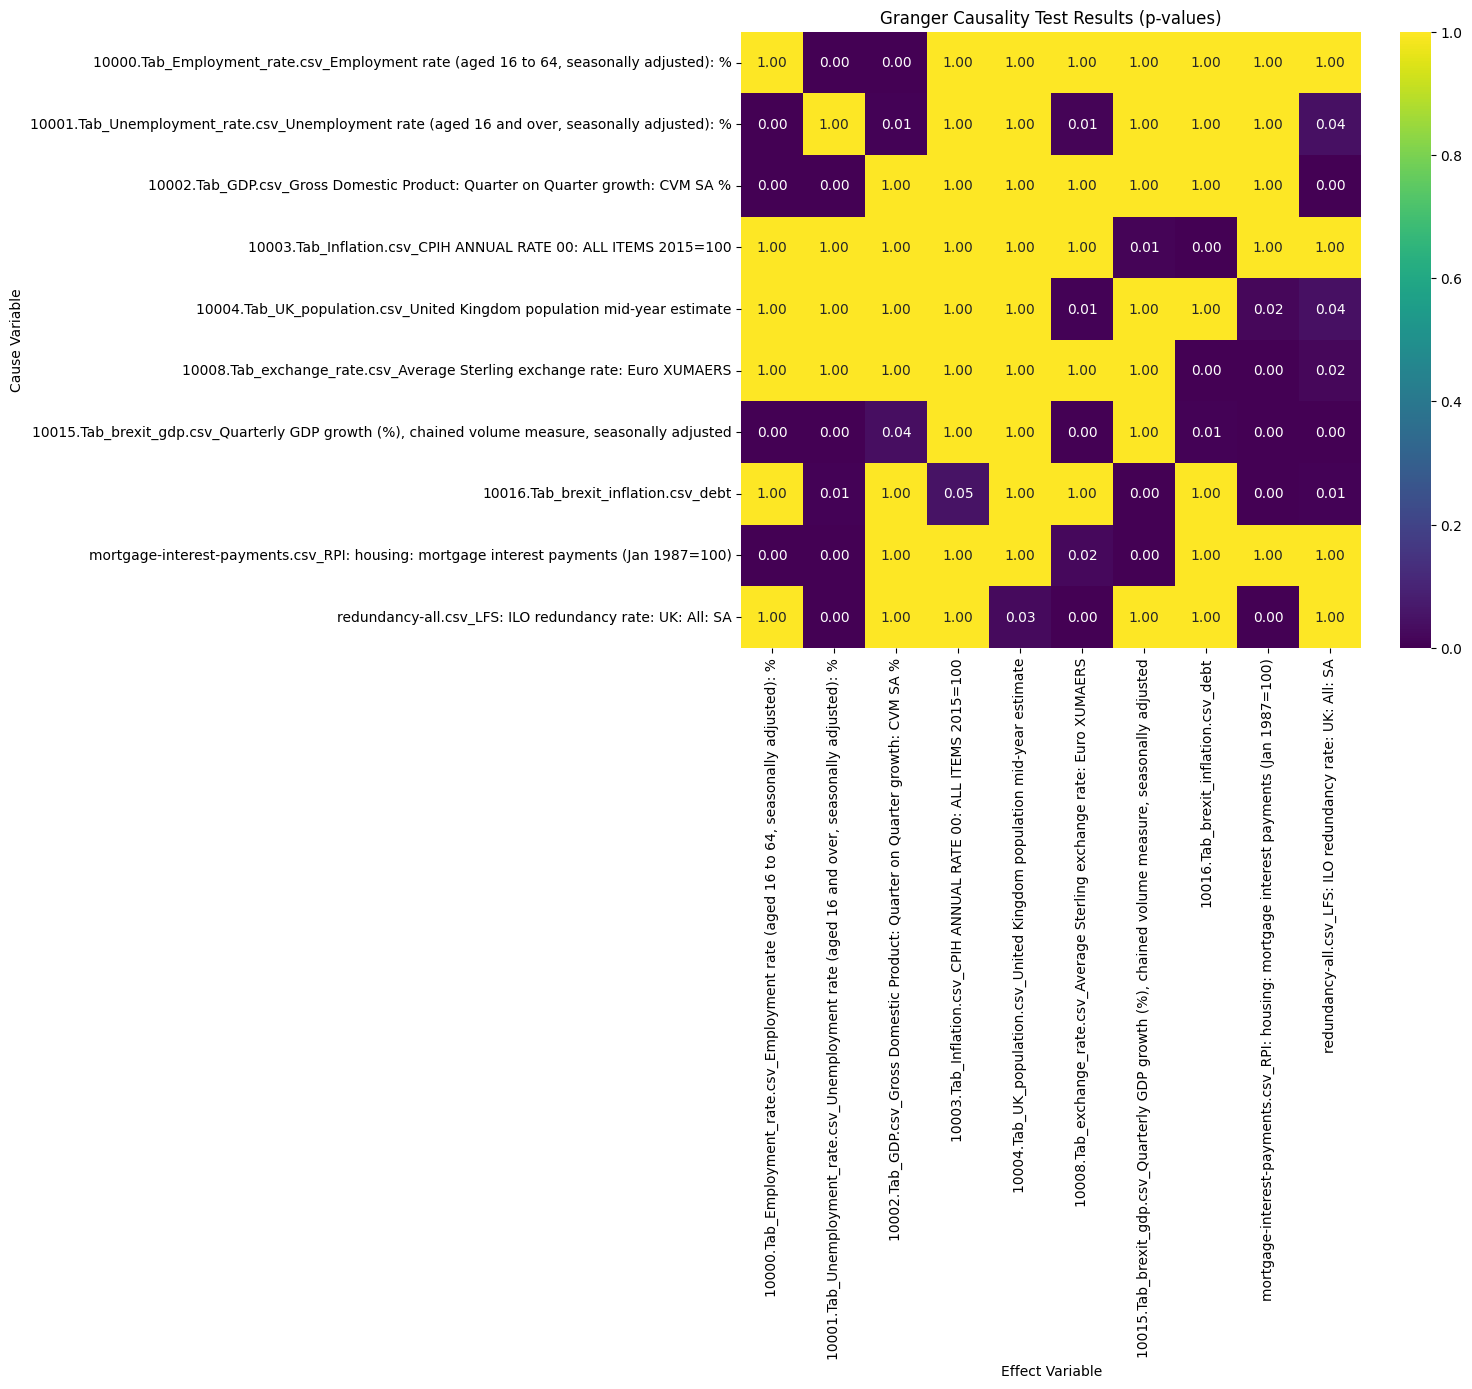

In [10]:
#@title p-values heatmap
def plot_granger_results(analyzer):
    """Visualizes Granger causality results using a heatmap."""

    # Extract relevant data for the heatmap
    causes = [result['cause'] for result in analyzer.causality_results]
    effects = [result['effect'] for result in analyzer.causality_results]
    p_values = [result['p_value'] for result in analyzer.causality_results]
    lags = [result['lag'] for result in analyzer.causality_results]  # Include lags

    # Create a DataFrame for the heatmap
    granger_df = pd.DataFrame({'cause': causes, 'effect': effects, 'p_value': p_values, 'lag': lags})

    # Group by 'cause' and 'effect' and take the minimum p-value for each group
    granger_df = granger_df.groupby(['cause', 'effect'])['p_value'].min().reset_index()

    granger_pivot = granger_df.pivot(index='cause', columns='effect', values='p_value')

    # Replace NaN with 1 (no causality)
    granger_pivot = granger_pivot.fillna(1)

    # Plotting with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(granger_pivot, annot=True, cmap='viridis', fmt=".2f", vmin=0, vmax=1)
    plt.title("Granger Causality Test Results (p-values)")
    plt.xlabel("Effect Variable")
    plt.ylabel("Cause Variable")
    plt.show()


# Example usage (assuming 'ca' is your GrangerCausalityAnalyzer instance):
plot_granger_results(ca)

# thats a lot of p=1.0, is that expected?